In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
combined_df = pd.read_csv('combined_df.csv', index_col=0)

The goal for this notebook is gain some insight into our data set that the baseline models can't give us. We're going to do some digging with more advanced ensemble models, test out which is the best for modeling this data set, then go on a deep dive into that model to see what we can learn about the data set. Let's first set up some functions that will allow us to sample, split, and model the data to see which model best predicts our training set. We will be looking at Gradient Boosting, Random Forest, Ada Boosting and K-Neighbors models to compare between the four of those.

In [3]:
def sample(df, target_variable, sample_df=False, sample_size=100):
    
    '''
    Pulls a user defined sample of the given data set, and keeps the class representation of the original data set.
    '''
    
    df.drop(df[df[target_variable] == 'OT'].index, inplace=True)
    appended_data = []
    perc_dict = {k:v/len(df) for k, v in list(df[target_variable].value_counts().items())[0:3]}
    
    for k in perc_dict.keys():
        n = round(sample_size * perc_dict[k])
        data = df[df[target_variable] == k].sample(n=n, random_state=11)
        appended_data.append(data)

    sample_df = pd.concat(appended_data)
    
    return sample_df

In [4]:
def split_data(df, target_variable, sample_df=False, sample_size=100):
    
    '''
    Function that does the train_test_split. Can sample the data set before hand, 
    or choose a specific pitcher by specifying first_name and last_name
    '''

    if sample_df:
        df = sample(df, target_variable, sample_df, sample_size)

    X = df.drop([target_variable, 'ab_id', 'batter_id', 'g_id', 'pitcher_id', 'px', 'pz',
                 'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN',
                 'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'UN', 'id', 'year', 'target'], axis=1).select_dtypes(exclude='object')
    y = df[target_variable]

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=47, stratify=y)
        
    return X_tr, X_te, y_tr, y_te

In [5]:
def find_best_params(df, target_variable, sample_df=False, sample_size=100):
    
    '''
    Finds the best parameters of each individual model via cross validation for future modeling use.
    '''
    
    X_train, X_test, y_train, y_test = split_data(df, target_variable, sample_df, sample_size)
    
    model_list = [RandomForestClassifier(), GradientBoostingClassifier(), 
                  AdaBoostClassifier(), KNeighborsClassifier()]
        
    for model in model_list:
        if model == model_list[0]:
            steps = [('rf', RandomForestClassifier(random_state=11))]
            param_grid = {'rf__n_estimators': np.arange(500, 5000, 500)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_rf = cv.best_params_['rf__n_estimators']
            
        elif model == model_list[1]:
            steps = [('gboost', GradientBoostingClassifier(random_state=11))]
            param_grid = {'gboost__n_estimators': np.arange(500, 1500, 500)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_gboost = cv.best_params_['gboost__n_estimators']
                        
        elif model == model_list[2]:
            steps = [('aboost', AdaBoostClassifier(random_state=11))]
            param_grid = {'aboost__n_estimators': np.arange(500, 5000, 500)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_aboost = cv.best_params_['aboost__n_estimators']
                        
        elif model == model_list[3]:
            steps = [('knn', KNeighborsClassifier())]
            param_grid = {'knn__n_neighbors': np.arange(9, 23, 2)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_knn = cv.best_params_['knn__n_neighbors']
        
    return best_rf, best_gboost, best_aboost, best_knn

In [6]:
def get_classification_report(df, target_variable, sample_df=False, sample_size=100):
    
    '''
    All chosen models get input from the find_best_params function, 
    and is used to fit and predict the data
    '''
    
    X_train, X_test, y_train, y_test = split_data(df, target_variable, sample_df, sample_size)
    
    best_rf, best_gboost, best_aboost, best_knn = find_best_params(df, target_variable, sample_df, sample_size)
    
    rf = RandomForestClassifier(n_estimators=best_rf, random_state=11)
    gboost = GradientBoostingClassifier(n_estimators=best_gboost, random_state=11)
    aboost = AdaBoostClassifier(n_estimators=best_aboost, random_state=11)
    knn = KNeighborsClassifier(n_neighbors=best_knn)
    
    rf_fit = rf.fit(X_train, y_train)
    gboost_fit = gboost.fit(X_train, y_train)
    aboost_fit = aboost.fit(X_train, y_train)
    knn_fit = knn.fit(X_train, y_train)
    
    rf_predict = rf.predict(X_test)
    gboost_predict = gboost.predict(X_test)
    aboost_predict = aboost.predict(X_test)
    knn_predict = knn.predict(X_test)

    target_names = rf.classes_
    print('Random Forest Classification Report:')
    print(classification_report(y_test, rf_predict, target_names=target_names))
    print('Gradient Boosting Classification Report:')
    print(classification_report(y_test, gboost_predict, target_names=target_names))
    print('Ada Boosting Classification Report:')
    print(classification_report(y_test, aboost_predict, target_names=target_names))
    print('K Neighbors Classification Report:')
    print(classification_report(y_test, knn_predict, target_names=target_names))
    

Now that we have our functions defined and ready to go, let's put them to use on a sample data set of 10,000, and 100,000 to see which model is the best performer.

In [7]:
get_classification_report(combined_df, 'pitch_type', sample_df=True, sample_size=10000)

Random Forest Classification Report:
              precision    recall  f1-score   support

          BB       0.39      0.29      0.33       792
          FB       0.59      0.74      0.66      1402
          OS       0.14      0.06      0.09       306

    accuracy                           0.52      2500
   macro avg       0.37      0.37      0.36      2500
weighted avg       0.47      0.52      0.48      2500

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.42      0.19      0.26       792
          FB       0.58      0.87      0.69      1402
          OS       0.27      0.01      0.02       306

    accuracy                           0.55      2500
   macro avg       0.42      0.36      0.32      2500
weighted avg       0.49      0.55      0.47      2500

Ada Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.45      0.13      0.20       792
          FB   

It looks like Ada boosting is the best performer for the smaller data set, let's take a look at a 100,000 sample and again see which model is the best.

In [8]:
get_classification_report(combined_df, 'pitch_type', sample_df=True, sample_size=100000)

Random Forest Classification Report:
              precision    recall  f1-score   support

          BB       0.37      0.30      0.33      7920
          FB       0.58      0.71      0.64     14018
          OS       0.19      0.09      0.12      3062

    accuracy                           0.50     25000
   macro avg       0.38      0.37      0.36     25000
weighted avg       0.47      0.50      0.48     25000

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.44      0.10      0.16      7920
          FB       0.57      0.94      0.71     14018
          OS       0.26      0.00      0.00      3062

    accuracy                           0.56     25000
   macro avg       0.42      0.35      0.29     25000
weighted avg       0.49      0.56      0.45     25000

Ada Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.41      0.07      0.12      7920
          FB   

Gradient boosting has begun to pull ahead of Ada boosting by the slimmest of margins. Neither model was able to predict the offspeed class, but gradient boosting had a better f1-score on the breaking ball class. We'll choose gradient boosting as our best model and go forward with that. We'll take a look at the feature importances for the gradient boosting model, as well as get into some resampling methods using SMOTE to hopefully train a more accurate model.

In [7]:
def gradient_boost(df, target_variable, resample=False, bb_mult=.75, os_mult=.5, sample_df=False, sample_size=100):
    
    '''
    Gradient boosting won as the best model. This function specifically focuses on gradient boosting and 
    gives feature importances in a graphical form.
    '''

    X_train, X_test, y_train, y_test = split_data(df, target_variable, sample_df, sample_size)
    
    if resample:
        sm = SMOTE(sampling_strategy= {'FB': y_train.value_counts().values[0],
                                       'BB': int(y_train.value_counts().values[0] * bb_mult),
                                       'OS': int(y_train.value_counts().values[0] * os_mult)})
        X_train, y_train = sm.fit_resample(X_train, y_train)

    steps = [('gboost', GradientBoostingClassifier(random_state=11))]
    param_grid = {'gboost__n_estimators': np.arange(100, 1100, 100)}

    pipeline = Pipeline(steps)
    cv = GridSearchCV(pipeline, param_grid, cv=3)
    cv.fit(X_train, y_train)

    best_gboost = cv.best_params_['gboost__n_estimators']

    gboost = GradientBoostingClassifier(n_estimators=best_gboost, random_state=11)
    gboost_fit = gboost.fit(X_train, y_train)
    gboost_predict = gboost.predict(X_test)

    feature_importances = pd.DataFrame(pd.Series(gboost.feature_importances_), columns=['Importance'])
    feature_importances.index = X_train.columns
    feature_importances = feature_importances.sort_values('Importance')

    plt.figure(figsize=(18,10))
    plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
    plt.title("Gradient Boosting Feature Importances (%)")
    plt.xlabel('Percentage Importance')
    plt.show()
    
    print(f'Gradient boost train accuracy:  {round(gboost.score(X_train, y_train) * 100, 2)}')
    print(f'Gradient boost test accuracy:   {round(gboost.score(X_test, y_test) * 100, 2)}')
    print('\n')
    
    target_names = gboost.classes_
    print('Gradient Boosting Classification Report')
    print(classification_report(y_test, gboost_predict, target_names=target_names))

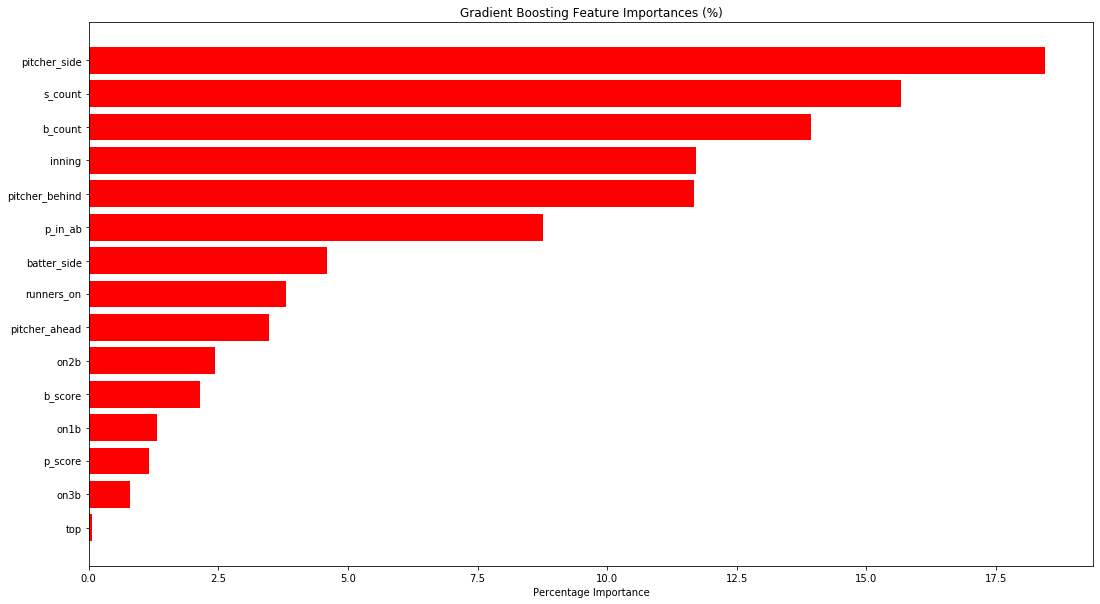

Gradient boost test accuracy: 0.5626062330905015
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.47      0.09      0.15    225509
          FB       0.57      0.95      0.71    399170
          OS       0.63      0.00      0.00     87199

    accuracy                           0.56    711878
   macro avg       0.56      0.35      0.29    711878
weighted avg       0.54      0.56      0.45    711878



In [10]:
gradient_boost(combined_df, 'pitch_type')

Taking a look at the gradient boosting model on the entire data set, it seems to have performed about as well as it did on the 100,000 data set. It did a good job of predicting the majority class, but not as well of a job predicting the two minority classes. Also to note are the feature importances. Pitcher side came out on top as the most important feature, which makes sense, right handed pitchers and left handed pitchers throw differently enough from one another that it certainly affects their pitch selection. Strike count and ball count being right behind pitcher side also makes sense, as pitchers will throw different pitches based on the count of the pitch.

Let's take a look into some resampling. We're going to oversample the minority classes (breaking balls and off-speed pitches) using the SMOTE function. We'll be looking into how feature importances, accuracies, and precisions/recalls change with a decreasing gap in class representation. First we'll take a look at 50% off-speed pitches and 75% breaking balls (percentages based off the majority class, fastballs).

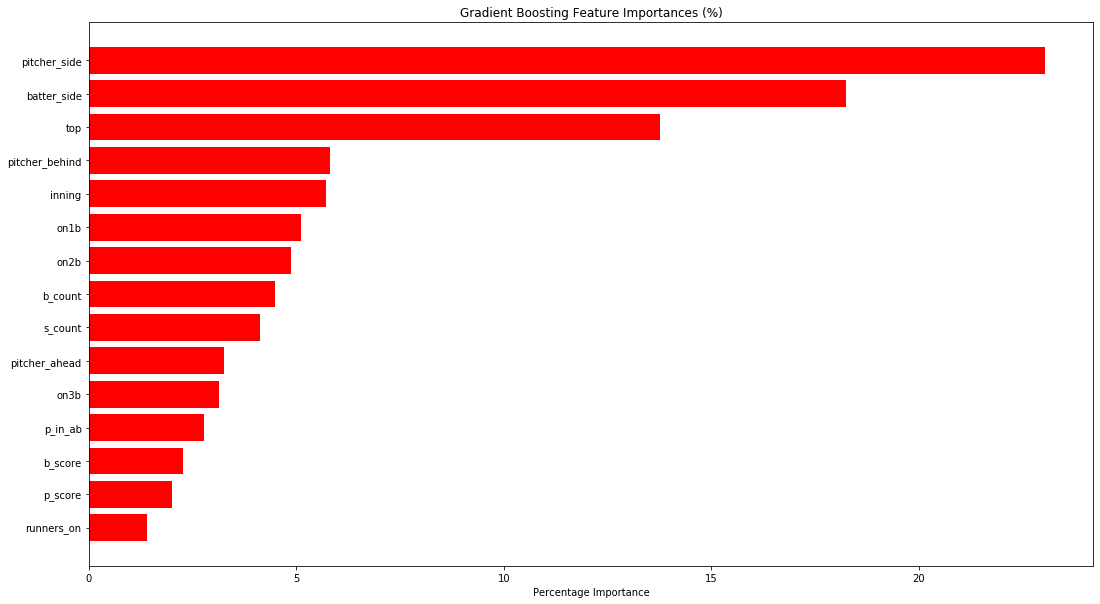

Gradient boost train accuracy: 54.55
Gradient boost test accuracy:  54.85


Gradient Boosting Classification Report
              precision    recall  f1-score   support

          BB       0.43      0.25      0.32      7920
          FB       0.59      0.82      0.68     14018
          OS       0.26      0.05      0.08      3062

    accuracy                           0.55     25000
   macro avg       0.42      0.38      0.36     25000
weighted avg       0.50      0.55      0.49     25000



In [9]:
gradient_boost(combined_df, 'pitch_type', resample=True, bb_mult=.75, os_mult=.5, sample_df=True, sample_size=100000)

Good thing to see to start out, it's able to predict some of the off-speed pitches. Also breaking ball scores have seemed to increase as well. That's a good sign for our resampling technique. Though it seems that fastball recall, as well as overall model accuracy has fallen off a bit. Let's try our next resampling technique and see if this trend continues.

For this test we'll have 87.5% breaking balls and 75% off-speed pitches compared to the majority class.

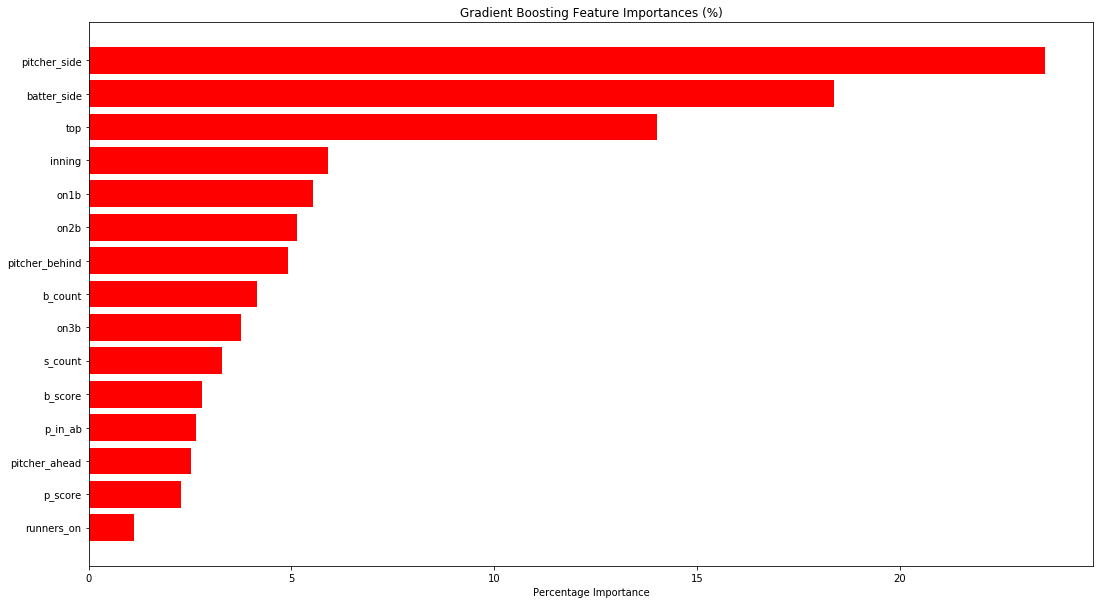

Gradient boost train accuracy: 55.81
Gradient boost test accuracy:  51.38


Gradient Boosting Classification Report
              precision    recall  f1-score   support

          BB       0.41      0.34      0.37      7920
          FB       0.61      0.68      0.64     14018
          OS       0.23      0.21      0.22      3062

    accuracy                           0.51     25000
   macro avg       0.42      0.41      0.41     25000
weighted avg       0.50      0.51      0.50     25000



In [10]:
gradient_boost(combined_df, 'pitch_type', resample=True, bb_mult=.875, os_mult=.75, sample_df=True, sample_size=100000)

Trend seems to continue. Fastball recall and f1-score dropped from 0.82/0.68 to 0.68/0.64. Overall model accuracy on the testing set has come down as well. However the model seems to be getting better at predicting the other classes. Scores for breaking balls and off-speed pitches have once again climbed. Let's try an even split of the three classes and see how our model performs.

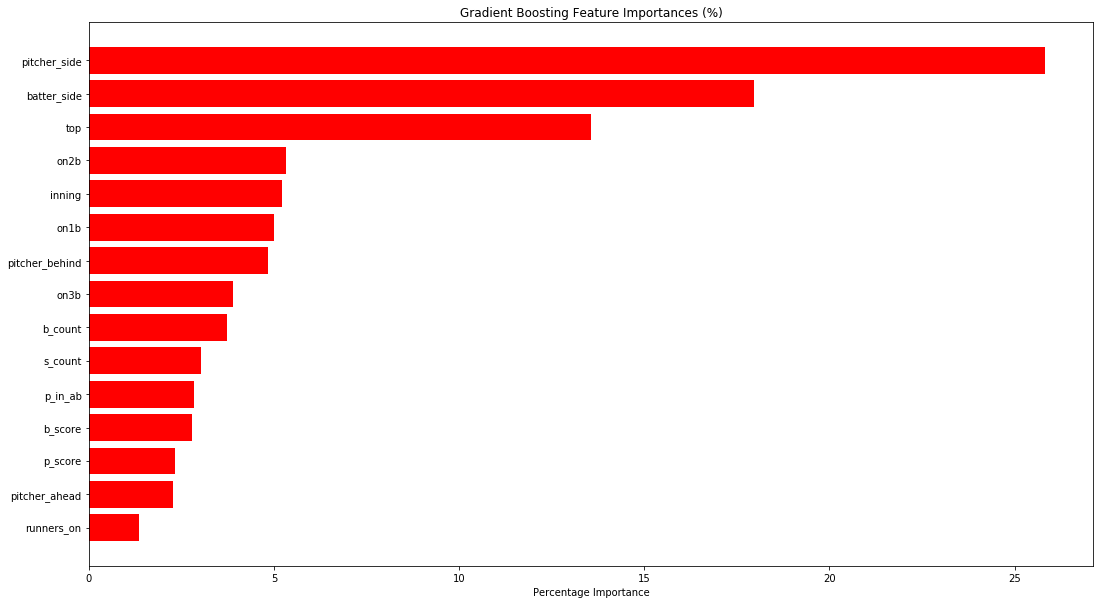

Gradient boost train accuracy: 56.82
Gradient boost test accuracy:  48.62


Gradient Boosting Classification Report
              precision    recall  f1-score   support

          BB       0.41      0.38      0.39      7920
          FB       0.62      0.59      0.60     14018
          OS       0.21      0.31      0.25      3062

    accuracy                           0.49     25000
   macro avg       0.41      0.42      0.42     25000
weighted avg       0.50      0.49      0.49     25000



In [11]:
gradient_boost(combined_df, 'pitch_type', resample=True, bb_mult=1, os_mult=1, sample_df=True, sample_size=100000)

The trend continues. This pattern of the model doing better on minority classes, but getting worse for the majority class has continued throughout our sampling tests. Also it seems our feature importances have changed as well. Pitcher side is still the top class, but ball count and strike count have dropped off to the middle of the pack and batter side has risen to the second most important feature.

In the context of a game this all makes sense. Pitchers have different strategies based on the handedness of the hitter, and this extends to different handed pitchers have different strategies to hitters. A right handed pitcher vs. a right handed batter will look much different than a right handed pitcher vs. a left handed batter. Same with lefty pitchers. 

So the gradient boosting model didn't predict pitches well at all, never rising above 56%. Let's take a look at some basic neural networks to see if they do any better.

## Simple Neural Network

Now that we have a good understanding of our data set from our gradient boosting model, we'll get some practice with Neural Networks in using two different neural networks. One from Scikit-Learn, and the other using Keras and Tensorflow.

Let's first take a look at the Scikit-Learn MLPClassifier on a 1,000,000 sample data set. This will allow for good model accuracy in much less time than modeling the whole data set. 

In [12]:
X_train, X_test, y_train, y_test = split_data(combined_df, 'pitch_type', sample_df=True, sample_size=1000000)

### Without resampling

First we'll take a look at how this model performs on the sampled data set without any resampling.

In [13]:
mlp = MLPClassifier(hidden_layer_sizes=(15,15,15,15,15,15,15,15), max_iter=10000, random_state=11)

In [14]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test), 2)}')
print('MLP Classifier Classification report')
print(classification_report(y_test, y_pred))

Test set accuracy: 0.56
MLP Classifier Classification report
              precision    recall  f1-score   support

          BB       0.47      0.10      0.16     79195
          FB       0.57      0.95      0.71    140182
          OS       0.00      0.00      0.00     30623

    accuracy                           0.56    250000
   macro avg       0.35      0.35      0.29    250000
weighted avg       0.47      0.56      0.45    250000



Essentially the same as our gradient boosting model. Good recall on the majority class, but struggling to predict the minority classes, and unable at all to predict our smallest class. Let's do some resampling again to see how that effects this neural network.

### With resampling

In [15]:
y_train.value_counts()

FB    420546
BB    237585
OS     91869
Name: pitch_type, dtype: int64

In [16]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0] / 1.5), 
                              'OS': int(y_train.value_counts().values[0] / 2)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

y_tr_res.value_counts()

FB    420546
BB    280364
OS    210273
Name: pitch_type, dtype: int64

First we'll take a look at 2/3 breaking balls and half off-speed pitches.

In [17]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test), 2)}')
print('MLP Classifier Classification report')
print(classification_report(y_test, res_pred))

Test set accuracy: 0.53
MLP Classifier Classification report
              precision    recall  f1-score   support

          BB       0.44      0.23      0.31     79195
          FB       0.59      0.78      0.67    140182
          OS       0.24      0.19      0.21     30623

    accuracy                           0.53    250000
   macro avg       0.42      0.40      0.40    250000
weighted avg       0.50      0.53      0.50    250000



Overall model accuracy went down, but the model was better able to pick out the minority classes, and was able to correctly predict some of the offspeed pitches. Let's decrease the gap in class representation, train again and see how it does.

In [18]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0] / 1.25), 
                              'OS': int(y_train.value_counts().values[0] / 1.5)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

FB    420546
BB    336436
OS    280364
Name: pitch_type, dtype: int64


In [19]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test), 2)}')
print('MLP Classifier Classification report')
print(classification_report(y_test, res_pred))

Test set accuracy: 0.48
MLP Classifier Classification report
              precision    recall  f1-score   support

          BB       0.42      0.39      0.40     79195
          FB       0.63      0.56      0.59    140182
          OS       0.21      0.36      0.27     30623

    accuracy                           0.48    250000
   macro avg       0.42      0.44      0.42    250000
weighted avg       0.51      0.48      0.49    250000



It seems like the same pattern is developing here like it did with the gradient boosting model. fastball recall/f1-score and model accuracy are decreasing, but everything else is increasing. Seems like this model is getting worse at predicting fastballs reliably, but better at predicting the minority classes. Let's do an even split on the class representation and take a look one more time. 

In [20]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0]), 
                              'OS': int(y_train.value_counts().values[0])}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

BB    420546
FB    420546
OS    420546
Name: pitch_type, dtype: int64


In [21]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test), 2)}')
print('MLP Classifier Classification report')
print(classification_report(y_test, res_pred))

Test set accuracy: 0.44
MLP Classifier Classification report
              precision    recall  f1-score   support

          BB       0.41      0.46      0.43     79195
          FB       0.67      0.41      0.51    140182
          OS       0.20      0.48      0.28     30623

    accuracy                           0.44    250000
   macro avg       0.42      0.45      0.41    250000
weighted avg       0.53      0.44      0.46    250000



For an even split of class representation, it seems to have settled on similar numbers that the gradient boosting model did. We also observed the same overall pattern with resampling that the gradient boosting model did. Let's take a look into a Keras and TensorFlow neural network and see if we observe the same thing.

# Keras and TensorFlow

## Without resampling

Unfortunately for this model we won't be able to use our split_data function here since that won't be able to turn our target variable into a categorical variable that this model requires. So we'll use the sample function to get a 1,000,000 sample of our data set, then map our target variable into integers, do our train_test_split, then turn our training set into categorical variables that the model will accept.

In [8]:
sample_df = sample(combined_df, 'pitch_type', sample_df=True, sample_size=1000000)
sample_df['pitch_type'] = sample_df['pitch_type'].map({'FB': 0, 'BB': 1, 'OS': 2})

X = sample_df.drop(['pitch_type', 'ab_id', 'batter_id', 'g_id', 'pitcher_id', 'px', 'pz',
                    'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN',
                    'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'UN', 'id', 'year', 'target'], axis=1).select_dtypes(exclude='object')
y = sample_df['pitch_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, stratify=y)

y_train = to_categorical(y_train)

So to build our model, we'll add an input column with a rectifier activation function, have that feed into the 15 hidden layers, then have our output layer have 3 nodes, one for each class, with a softmax activation functions to predict the probability of each class. We'll use 50 epochs to get an adequate amount of training for each fit call, then take a look at the results in terms of loss, accuracy, and each prediction's classification report.

In [5]:
model = Sequential()
model.add(Dense(12, input_dim=15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [26]:
accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Keras training model loss: {accuracy[0]}')
print(f'Keras training model accuracy: {accuracy[1]}')
print('\n')
keras_classes = model.predict_classes(X_test)
print(classification_report(y_test, keras_classes))

Keras training model loss: 0.9125269130897522
Keras training model accuracy: 0.5608973333333334


              precision    recall  f1-score   support

           0       0.56      0.99      0.72    140182
           1       0.48      0.02      0.04     79195
           2       0.00      0.00      0.00     30623

    accuracy                           0.56    250000
   macro avg       0.35      0.34      0.25    250000
weighted avg       0.47      0.56      0.41    250000



The first model we used on the sampled data set with no resampling. Seems to have turned out similarly to our previous models, doing really well on the majority classes (actually better on this model), and not as well on the minority classes. Let's get into some resampling and see if the same pattern as the other two models happens again.

### With Resampling

In [6]:
sample_df = sample(combined_df, 'pitch_type', sample_df=True, sample_size=1000000)
sample_df['pitch_type'] = sample_df['pitch_type'].map({'FB': 0, 'BB': 1, 'OS': 2})

X = sample_df.drop(['pitch_type', 'ab_id', 'batter_id', 'g_id', 'pitcher_id', 'px', 'pz',
                    'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN',
                    'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'UN', 'id', 'year', 'target'], axis=1).select_dtypes(exclude='object')
y = sample_df['pitch_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, stratify=y)

In [8]:
sm = SMOTE(sampling_strategy={0:     y_train.value_counts().values[0], 
                              1: int(y_train.value_counts().values[0] * .75), 
                              2: int(y_train.value_counts().values[0] * .5)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

0    420546
1    315409
2    210273
Name: pitch_type, dtype: int64

In [9]:
y_tr_res = to_categorical(y_tr_res)

In [12]:
model.fit(X_tr_res, y_tr_res, epochs=50, batch_size=5, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [13]:
accuracy = model.evaluate(X_tr_res, y_tr_res, verbose=0)
print(f'Keras training model loss: {accuracy[0]}')
print(f'Keras training model accuracy: {accuracy[1]}')

keras_classes = model.predict_classes(X_test)
print(classification_report(y_test, keras_classes))

Keras training model loss: 0.9902409381679032
Keras training model accuracy: 0.47248337609966073
              precision    recall  f1-score   support

           0       0.60      0.68      0.64    140182
           1       0.41      0.43      0.42     79195
           2       0.25      0.05      0.09     30623

    accuracy                           0.53    250000
   macro avg       0.42      0.39      0.38    250000
weighted avg       0.49      0.53      0.50    250000



For this model it seems like the same pattern as before is happening again. Worse on model accuracy, majority class precision/f1-score, better on everything else. The numbers are a bit different, this neural network is the best at predicting the majority class, and not performing as well as our other models on the minority classes. Let's do another resample and see how the model does.

In [7]:
sm = SMOTE(sampling_strategy={0:     y_train.value_counts().values[0], 
                              1: int(y_train.value_counts().values[0] * .875), 
                              2: int(y_train.value_counts().values[0] * .75)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

0    420546
1    367977
2    315409
Name: pitch_type, dtype: int64


In [8]:
y_tr_res = to_categorical(y_tr_res)

In [9]:
model.fit(X_tr_res, y_tr_res, epochs=50, batch_size=5, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [10]:
accuracy = model.evaluate(X_tr_res, y_tr_res, verbose=0)
print(f'Keras training model loss: {accuracy[0]}')
print(f'Keras training model accuracy: {accuracy[1]}')

keras_classes = model.predict_classes(X_test)
print(classification_report(y_test, keras_classes))

Keras training model loss: 1.005011971135433
Keras training model accuracy: 0.46182101796103525
              precision    recall  f1-score   support

           0       0.66      0.39      0.49    140182
           1       0.39      0.53      0.45     79195
           2       0.20      0.40      0.27     30623

    accuracy                           0.43    250000
   macro avg       0.42      0.44      0.40    250000
weighted avg       0.52      0.43      0.45    250000



The recall on the majority class really fell off here, and minority classes jumped up a lot. Interesting how this model is performing much differently than the ones before. The same overall pattern is happening as our gradient boosting and MLP Classifier models as before, but this model seems to be taking it to another level. 

In [7]:
sm = SMOTE(sampling_strategy={0:     y_train.value_counts().values[0], 
                              1: int(y_train.value_counts().values[0]), 
                              2: int(y_train.value_counts().values[0])}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

2    420546
1    420546
0    420546
Name: pitch_type, dtype: int64


In [8]:
y_tr_res = to_categorical(y_tr_res)

In [9]:
model.fit(X_tr_res, y_tr_res, epochs=50, batch_size=5, verbose=0)

In [10]:
accuracy = model.evaluate(X_tr_res, y_tr_res, verbose=0)
print(f'Keras training model loss: {accuracy[0]}')
print(f'Keras training model accuracy: {accuracy[1]}')

keras_classes = model.predict_classes(X_test)
print(classification_report(y_test, keras_classes))

Keras training model loss: 0.9961218506889081
Keras training model accuracy: 0.48332327604293823
              precision    recall  f1-score   support

           0       0.68      0.35      0.47    140182
           1       0.41      0.45      0.43     79195
           2       0.19      0.57      0.29     30623

    accuracy                           0.41    250000
   macro avg       0.43      0.46      0.39    250000
weighted avg       0.53      0.41      0.43    250000



Very interesting how this model is performing so much differently than our other ones. It seems like the f1-scores of the three classes have leveled out, but the precisions and recalls are varying wildly. I would love to get more into this, but for the sake of time it's best to end here and draw some conclusions from our models.

# Final Thoughts

After looking at all the models built, and looking at feature importances for the gradient boosting models, it seems like the side the pitcher is pitching from, how many balls in the count there are, how many strikes in the count there are, and what side the batter is hitting from are the most important variables for predicting the next pitch that is coming. Both the original gradient boosting model with the normal class representation, as well as all the resampled versions of the same model had pitcher side on top as the most important feature for predicting pitches. This certainly makes sense in the context of a game. Right handed pitchers are going to throw different pitches in different situations than left handed pitchers. Left handers and right handers match up differently against batters and will throw pitches based on these matchups. A right handed batter vs. left handed pitcher will match up differently than a left handed batter vs. left handed pitcher, and different pitches will be chosen based on these matchups. How many balls and strikes in the count will also dictate what pitch is thrown. Pitchers with more strikes in the count will be looking to stay ahead of batters and throw more breaking balls or off speed pitches. While pitchers who are behind in the count (more balls) will want to throw more fastballs to catch up. Ultimately all of these factors go into choosing what pitch is coming next.